<font color=darkred>

# Soc220: Computational Text Analysis
## Lab 8: Topic models II

<br>


<img src="images/temp_viz.jpg" style="width: 650px"/>

***

Today:

- Using cross-validation to pick the optimal number of topics
- Structural topic models

***
    
   

#### Load data:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
# same as usual
import pickle

df_texts = pickle.load(open("df_proceedings_monarch_and_date.p","rb"))

In [3]:
# inspect
import pandas as pd

df_texts.head()

,date,monarch,text
0,1660_11,charles2,On the sixth of November the Parliament met ac...
1,1660_4,charles2,"CHARLES R."", ""Trusty, and Wellbeloved, We gree..."
2,1661_11,charles2,After a Recess of almost four Months the Parli...
3,1661_5,charles2,"On the 8th of May the new Parliament met, and ..."
4,1663_2,charles2,"On February 18, 16623. the Parliament met afte..."


In [4]:
#new dummy variable: are we at war or not?

df_texts['war'] = 0

war_years = ['1665_10', '1666_9', '1667_10','1689_1', '1689_10',
       '1689_2', '1689_5', '1690_10', '1690_3', '1691_10', '1692_11',
       '1693_11', '1694_11', '1695_11', '1696_10', '1697_12','1702_10', '1702_12',
       '1702_5', '1703_11', '1704_10', '1704_2', '1704_4', '1705_10',
       '1706_12', '1706_4', '1707_11', '1707_4', '1708_11', '1709_11',
       '1710_11', '1711_12', '1711_2', '1712_3']

df_texts.loc[df_texts['date'].isin(war_years), 'war'] = 1

df_texts

,date,monarch,text,war
0,1660_11,charles2,On the sixth of November the Parliament met ac...,0
1,1660_4,charles2,"CHARLES R."", ""Trusty, and Wellbeloved, We gree...",0
2,1661_11,charles2,After a Recess of almost four Months the Parli...,0
3,1661_5,charles2,"On the 8th of May the new Parliament met, and ...",0
4,1663_2,charles2,"On February 18, 16623. the Parliament met afte...",0
5,1664_11,charles2,"After a Recess of above six Months, the Parlia...",0
6,1664_3,charles2,"March 16, after an interval of near eight Mont...",0
7,1665_10,charles2,"The Plague raging in London and Westminster, t...",1
8,1666_9,charles2,"'September 21, the Parliament, after several P...",1
9,1667_10,charles2,"'On the 10th day of October, after a double P...",1


In [5]:
#write to excel in order to retain complexity of text
writer = pd.ExcelWriter('efr_tm.xlsx')
df_texts.to_excel(writer,'Sheet1') #index=False? # , ,encoding="utf-8" #r'efr_tm.csv', sep=';'

In [6]:
#list local files to check if excel file is still there.
!ls

df_proceedings_monarch_and_date.p lab8_final.ipynb
efr_tm.xlsx                       lab8_stm.R
images                            stmVignette.pdf


<font color=darkgreen>

### Cross-validation and hyperparameter tuning (from lab 6)

<img src="images/ten_fold.png" style="width: 400px;" />

- Hyperparameters are the meta level settings of each algorithm. We can specify them if we have prior theory to do so, or we can aks the machine to tune them, typically using something called gradient descent (it's typically computationally impossible to test *all* possible combinations, so what the computer does is [increment down a slope of the loss function](https://en.wikipedia.org/wiki/Gradient_descent).)
- The 'learning rate' parameter is the rate at which one descends the descent. (Typically 'C' parameter in scikit-learn)
- In 10-fold cross validation, one sample is used as the training data while the other 9 are used to train the model, and then we iterate through each fold.
- The results from each fold are then typically averaged together.
- That averaged result is then used to predict on the set aside test data.

#### Cross validation:

* Gridsearch in a dictionary of parameters and a function.
* GridSearchCV itself takes in parameters like specifying the number of folds, the loss function, and the learning rate.

#### Viz of model comparison

https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

<img src="images/lda_diagram.png" style="width: 600px;" />

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.LatentDirichletAllocation.html

In [7]:
#fit topic model as before
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

tf_vectorizer = CountVectorizer(
                                #strip_accents = 'unicode',
                                stop_words = 'english',
                                lowercase = True,
                                max_features=None,
                                max_df = 0.90,
                                min_df = .2
)

dtm_tf = tf_vectorizer.fit_transform(df_texts['text'])
print(dtm_tf.shape)

(111, 2300)


<font color=darkgreen>

### LDA model fit statistics.

* Perplexity is "average surprise" vs maximum log-likelihood which is "our total surprise."
Intuitively:
- A uniform distribution has high perplexity because it is hard to predict a random draw from it. (e.g. predict the next roll of a six-sided die)
– A peaked distribution has low perplexity because it is easy to predict the outcome of a random draw from it. (e.g. predict the height of a random sample of human beings)
- In general, minimizing perplexity is a "less complex" model.

### $$ L(w_d)  = \sum_d \log p(w_d|\Theta,\alpha)$$

Likelihood of an unseen document ($w_d$) is the sum of the log probabilities of given that document, against the topic matrix ($\Theta$) and the hyperparameter $\alpha$ of the topic distribution of documents. 

### $$ \text{perplexity} (w) = \text{exp}{- \frac{L(w)}{\text{count of tokens}} } $$

In [8]:
perplexity_of_models = []
for n in (range(2,20)):
    model = LatentDirichletAllocation(n_components=n,learning_method='online')
    model.fit(dtm_tf)
    perplexity_of_models.append(model.perplexity(dtm_tf)) 

In [9]:
perplexity_of_models

[1412.8900398281216,
 1359.3649305683066,
 1352.3304173162257,
 1309.9135827301568,
 1319.3014149838473,
 1307.370414157485,
 1310.6945093241625,
 1330.1492796230502,
 1330.870553266719,
 1344.988701009161,
 1356.768716081282,
 1344.4422000594084,
 1343.4924658313166,
 1388.0024690601017,
 1376.6639614731157,
 1372.4658685275142,
 1412.1068375223854,
 1438.8806412753909]

In [10]:
import numpy as np

#find the minimization of perplexity
np.argmin(perplexity_of_models)

5

In [11]:
loglikelihood_of_models = []
for n in (range(2,20)):
    model = LatentDirichletAllocation(n_components=n,learning_method='online')
    model.fit(dtm_tf)
    loglikelihood_of_models.append(model.score(dtm_tf)) 

In [12]:
loglikelihood_of_models

[-3025027.6100607803,
 -3021279.9252986116,
 -3010356.213952217,
 -3010054.9211771325,
 -3007358.6862623035,
 -2997150.5248254538,
 -3006483.866351179,
 -3003826.982705942,
 -3007705.6853850647,
 -3003149.035905044,
 -3028543.8814738397,
 -3025174.0363382585,
 -3018297.278687997,
 -3020888.4486936103,
 -3027405.6329127513,
 -3028216.7403017934,
 -3030601.2810519496,
 -3039911.945868356]

In [13]:
#find the maximum loglikelihood
np.argmax(loglikelihood_of_models)

5

In [14]:
lda_tf = LatentDirichletAllocation(n_components=5,
                                   learning_method='online',
                                   learning_offset=50, #A (positive) parameter that downweights early iterations in online learning. It should be greater than 1.0. In the literature, this is called tau_0.
                                   #max_iter=20,
                                   random_state=450)

lda_tf.fit(dtm_tf)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=50,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=5, n_jobs=1, n_topics=None, perp_tol=0.1,
             random_state=450, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [15]:
#visualize same as before
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

#pyLDAvs takes in the fit lda, the dtm, and then method of creating the dtm
pyLDAvis.sklearn.prepare(lda_tf, dtm_tf, tf_vectorizer)

/Users/zwehrwein/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
3      45.038975        1       1  0.057812 -0.018758
4      24.505930        1       2  0.003359  0.041384
1      13.927556        1       3 -0.025847  0.010055
2      12.984609        1       4 -0.034260 -0.035262
0       3.542929        1       5 -0.001064  0.002581, topic_info=     Category         Freq         Term        Total  loglift  logprob
term                                                                  
211   Default  1229.000000         army  1229.000000  30.0000  30.0000
1843  Default   839.000000        royal   839.000000  29.0000  29.0000
1581  Default   605.000000       prince   605.000000  28.0000  28.0000
0     Default   956.000000          000   956.000000  27.0000  27.0000
1455  Default  1871.000000        ought  1871.000000  26.0000  26.0000
945   Default  1676.000000    gentleman  1676.000000  25.0000  25.0000
370   Default   557.000000        civil   557.000000  24.0000  24.0000
1277  Default  1548.000000          man  1548.000000  23.0000  23.0000
1345  Default  1300.000000       motion  1300.000000  22.0000  22.0000
1835  Default  1445.000000        right  1445.000000  21.0000  21.0000
1660  Default  1300.000000       public  1300.000000  20.0000  20.0000
504   Default  1255.000000      country  1255.000000  19.0000  19.0000
1661  Default  1094.000000      publick  1094.000000  18.0000  18.0000
2128  Default  1309.000000        trade  1309.000000  17.0000  17.0000
1827  Default   592.000000      revenue   592.000000  16.0000  16.0000
1706  Default  1530.000000       reason  1530.000000  15.0000  15.0000
1244  Default   361.000000         list   361.000000  14.0000  14.0000
1391  Default   878.000000       number   878.000000  13.0000  13.0000
335   Default   435.000000         cent   435.000000  12.0000  12.0000
1974  Default  1004.000000        spain  1004.000000  11.0000  11.0000
2230  Default   191.000000        wales   191.000000  10.0000  10.0000
2145  Default   460.000000       troops   460.000000   9.0000   9.0000
966   Default   919.000000      granted   919.000000   8.0000   8.0000
1042  Default   947.000000   honourable   947.000000   7.0000   7.0000
1751  Default   526.000000        reign   526.000000   6.0000   6.0000
942   Default  1237.000000      general  1237.000000   5.0000   5.0000
94    Default  1438.000000      address  1438.000000   4.0000   4.0000
2046  Default   869.000000          sum   869.000000   3.0000   3.0000
1687  Default  1478.000000     question  1478.000000   2.0000   2.0000
2292  Default  1180.000000        years  1180.000000   1.0000   1.0000
...       ...          ...          ...          ...      ...      ...
1320   Topic5    24.001127     military   158.328698   1.4536  -6.4262
1743   Topic5     5.743836     regarded    38.746640   1.4313  -7.8562
1920   Topic5    38.052894      settled   260.638956   1.4161  -5.9653
318    Topic5     9.876914     capacity    68.655417   1.4013  -7.3141
1513   Topic5     7.269241      pleases    51.550555   1.3813  -7.6206
1843   Topic5   117.388655        royal   839.367557   1.3731  -4.8388
854    Topic5    40.511368       family   291.618107   1.3664  -5.9027
1960   Topic5    24.044783     soldiers   181.676236   1.3179  -6.4244
2145   Topic5    57.091332       troops   460.256197   1.2531  -5.5596
0      Topic5   111.367684          000   956.367420   1.1899  -4.8915
1827   Topic5    70.642999      revenue   592.151212   1.2141  -5.3467
766    Topic5    41.351566  established   349.612779   1.2055  -5.8822
1751   Topic5    53.352964        reign   526.131558   1.0516  -5.6274
211    Topic5    90.245719         army  1229.913728   0.7281  -5.1018
2041   Topic5    49.815281   sufficient   572.275888   0.8989  -5.6960
1835   Topic5    86.599097        right  1445.379983   0.5254  -5.1430
1455   Topic5    90.793928        ought  1871.150148   0.3145  -5.0957
1345   Topic5    74.288249   

<font color=darkgreen>

#### My owning coding scheme:

1. 'religion'
2. 'judiciary'
3. 'taxes'
4. 'misc'
5. 'army'

In [16]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        #components_ : array, [n_topics, n_features]
        #components_[i, j] = word j in topic i
        print('\n')
        print("Topic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

In [17]:
# extract topic distribution
topic_dist = lda_tf.transform(dtm_tf)
topic_dist

topic_dist_df = pd.DataFrame(topic_dist,columns=['religion','judiciary','taxes','misc','military']) #

topic_dist_df.head()

,religion,judiciary,taxes,misc,military
0,0.000349,0.000349,0.030833,0.968121,0.000349
1,0.000093,0.000092,0.000093,0.975043,0.024679
2,0.000152,0.000152,0.062961,0.936584,0.000152
3,0.000149,0.000149,0.000149,0.983301,0.016251
4,0.000176,0.000176,0.000176,0.970827,0.028645


In [18]:
# join topic list to doc list

df_texts_topics = topic_dist_df.join(df_texts)
df_texts_topics.head()

,religion,judiciary,taxes,misc,military,date,monarch,text,war
0,0.000349,0.000349,0.030833,0.968121,0.000349,1660_11,charles2,On the sixth of November the Parliament met ac...,0
1,0.000093,0.000092,0.000093,0.975043,0.024679,1660_4,charles2,"CHARLES R."", ""Trusty, and Wellbeloved, We gree...",0
2,0.000152,0.000152,0.062961,0.936584,0.000152,1661_11,charles2,After a Recess of almost four Months the Parli...,0
3,0.000149,0.000149,0.000149,0.983301,0.016251,1661_5,charles2,"On the 8th of May the new Parliament met, and ...",0
4,0.000176,0.000176,0.000176,0.970827,0.028645,1663_2,charles2,"On February 18, 16623. the Parliament met afte...",0


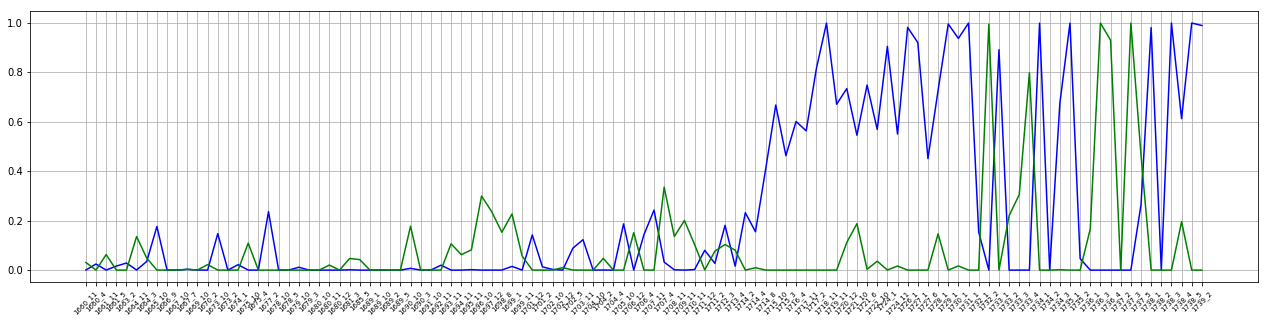

In [19]:
import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(22, 5))

plt.plot(df_texts_topics.date,df_texts_topics['military'],color='blue')
#plt.plot(df_texts_topics.date,df_texts_topics['religion'],color='blue')
#plt.plot(df_texts_topics.date,df_texts_topics['misc'],color='blue')
plt.plot(df_texts_topics.date,df_texts_topics['taxes'],color='green')
#plt.plot(df_texts_topics.date,df_texts_topics['judiciary'],color='blue')

plt.xticks(df_texts.date[::], rotation=45,size=7)
#plt.title()
plt.grid()
plt.show()

In [20]:
topics = ['religion','judiciary','taxes','misc','military']
#selection by index
#X = df_texts_topics.iloc[:,0:15]
#selection by topics
X = df_texts_topics[topics]
y = df_texts_topics['war']

In [21]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
result=logit_model.fit()

Optimization terminated successfully.
         Current function value: 0.457540
         Iterations 9


In [22]:
result.summary2()

/Users/zwehrwein/anaconda3/lib/python3.6/site-packages/statsmodels/iolib/summary2.py:529: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  dat.ix[:, 0] = [str(x) + int(pad_index) * ' ' for x in dat.ix[:, 0]]
/Users/zwehrwein/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:992: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
/Users/zwehrwein/anaconda3/lib/python3.6/site-packages/statsmodels/iolib/summary2.py:529: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org

<class 'statsmodels.iolib.summary2.Summary'>
"""
                        Results: Logit
===============================================================
Model:              Logit            No. Iterations:   9.0000  
Dependent Variable: war              Pseudo R-squared: 0.257   
Date:               2018-03-29 15:10 AIC:              111.5738
No. Observations:   111              BIC:              125.1214
Df Model:           4                Log-Likelihood:   -50.787 
Df Residuals:       106              LL-Null:          -68.389 
Converged:          1.0000           Scale:            1.0000  
----------------------------------------------------------------
            Coef.   Std.Err.     z     P>|z|    [0.025    0.975]
----------------------------------------------------------------
religion   -4.8624    8.5269  -0.5702  0.5685  -21.5748  11.8501
judiciary  -6.0115    5.4882  -1.0953  0.2734  -16.7682   4.7453
taxes      -1.6418    1.2391  -1.3250  0.1852   -4.0704   0.7867
misc        0.2758    0.2873   0.9600  0.3371   -0.2872   0.8388
military   -4.9740    1.6665  -2.9847  0.0028   -8.2402  -1.7077
===============================================================

"""

<font color=darkgreen>

Rough interpretation:

- Issues with the domestic judiciary are less discussed during times of war, as is our `misc` category.
- Religion, taxes, and the military all do come up.
- The only "statistically significant" observation is religion which makes sense because given that the fight between the English and French was also a Protestant vs. Catholics fight (and fear of domestic Catholics rising up and seizing power in the name of the "one true church").



## The linear algebra approach to topic models: NMF


<img src="images/nmf2.png" style="width: 400px;" />


<img src="images/nmf.png" style="width: 200px;" />



- Intuition: just like PCA.
- Non-negative Matrix Factorization factors high-dimensional vectors into a low-dimensional representation.
- NMF creates "non-negative" coefficients which factor the complex matrix
- Document-term matrix (V)
- Term-feature (W)
- Feature-document (H) -- the weights of each topic in each document.

https://en.wikipedia.org/wiki/Non-negative_matrix_factorization

- Key: because this is a linear algebraic approach (and not a probalistic one), you will get the same result every single time.

In [23]:
#nmf takes into tfidf
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

#tfidf for texts
tfidf_texts = tfidf_vectorizer.fit_transform(df_texts['text'])
tfidf_feature_names = tfidf_vectorizer.get_feature_names()

In [24]:
# Run NMF; same as above.
from sklearn.decomposition import NMF

nmf_model = NMF(n_components=5) #
#.fit(tfidf)

#fit the model
nmf_model.fit(tfidf_texts)

nmf_W = nmf_model.transform(tfidf_texts)
nmf_H = nmf_model.components_

In [25]:
#again, takes in the model, the tfidf or tf matrix, and the vectorizer used.
pyLDAvis.sklearn.prepare(nmf_model, tfidf_texts, tfidf_vectorizer)

/Users/zwehrwein/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:387: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  topic_term_dists = topic_term_dists.ix[topic_order]


PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
2      22.740685        1       1  0.054050  0.134628
4      19.692520        1       2  0.169413  0.005100
3      19.371956        1       3 -0.151318 -0.040513
1      19.368624        1       4 -0.104965  0.079940
0      18.826215        1       5  0.032820 -0.179155, topic_info=      Category       Freq           Term      Total  loglift  logprob
term                                                                 
7154   Default   4.000000      lordships   4.000000  30.0000  30.0000
5362   Default   4.000000      gentleman   4.000000  29.0000  29.0000
9199   Default   5.000000        publick   5.000000  28.0000  28.0000
2695   Default   2.000000     conference   2.000000  27.0000  27.0000
10133  Default  12.000000           said  12.000000  26.0000  26.0000
4146   Default   2.000000         duties   2.000000  25.0000  25.0000
2503   Default   2.000000  commissioners   2.000000  24.0000  24.0000
5683   Default   4.000000           hath   4.000000  23.0000  23.0000
12287  Default   2.000000        walpole   2.000000  22.0000  22.0000
710    Default   6.000000            act   6.000000  21.0000  21.0000
9195   Default   3.000000         public   3.000000  20.0000  20.0000
2077   Default   3.000000           case   3.000000  19.0000  19.0000
9638   Default   3.000000       religion   3.000000  18.0000  18.0000
655    Default   1.000000       accompts   1.000000  17.0000  17.0000
7708   Default   3.000000         motion   3.000000  16.0000  16.0000
4543   Default   2.000000         europe   2.000000  15.0000  15.0000
8688   Default   2.000000         popish   2.000000  14.0000  14.0000
11665  Default   1.000000          trial   1.000000  13.0000  13.0000
4161   Default   3.000000           earl   3.000000  12.0000  12.0000
12622  Default   4.000000           year   4.000000  11.0000  11.0000
4365   Default   1.000000    engagements   1.000000  10.0000  10.0000
11591  Default   1.000000    tranquility   1.000000   9.0000   9.0000
5876   Default   2.000000     honourable   2.000000   8.0000   8.0000
11457  Default   2.000000       thousand   2.000000   7.0000   7.0000
12573  Default   1.000000            wou   1.000000   6.0000   6.0000
2510   Default   5.000000      committee   5.000000   5.0000   5.0000
1871   Default   2.000000        britain   2.000000   4.0000   4.0000
7404   Default   2.000000       measures   2.000000   3.0000   3.0000
4283   Default   1.000000        emperor   1.000000   2.0000   2.0000
9100   Default   1.000000       proposed   1.000000   1.0000   1.0000
...        ...        ...            ...        ...      ...      ...
9572    Topic5   0.616942       regiment   0.748752   1.4763  -6.7348
8249    Topic5   1.206834           paid   1.759595   1.2928  -6.0638
710     Topic5   3.295095            act   6.520845   0.9874  -5.0594
5432    Topic5   0.812954          goods   1.077482   1.3882  -6.4589
9195    Topic5   2.125711         public   3.833433   1.0803  -5.4977
11457   Topic5   1.455484       thousand   2.365704   1.1842  -5.8765
2140    Topic5   0.859728           cent   1.201799   1.3350  -6.4030
5468    Topic5   1.395952        granted   2.441644   1.1108  -5.9182
12622   Topic5   2.126814           year   4.597765   0.8990  -5.4972
10133   Topic5   4.015085           said  12.157183   0.5621  -4.8618
9291    Topic5   1.342715          queen   2.498812   1.0488  -5.9571
11129   Topic5   1.282593            sum   2.354736   1.0624  -6.0029
8138    Topic5   1.135017        ordered   1.985029   1.1109  -6.1252
11923   Topic5   0.925146          union   1.426423   1.2369  -6.3296
8390    Topic5   0.775425        payment   1.080545   1.3381  -6.5062
9842    Topic5   1.283970       resolved   2.746624   0.9095  -6.0019
8747    Topic5   1.073594         pounds   2.033444   1.0312  -6.1808
5495    Topic5   0.852720   greatbritain   1.343305   1.2155  -6.4111
2510    T